Классификация по принципу "Есть дефект/Нет дефекта/Дефект не распознан"

Подход не сработал, метрики плохие

# Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms, models
from collections import OrderedDict
from PIL import Image
import PIL
from torch.optim import lr_scheduler
import os
from sklearn.model_selection import train_test_split
import shutil
import gc
from tqdm import tqdm
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, Dataset
from IPython.display import clear_output

In [2]:
RANDOM_STATE = 42

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Формирование выборки для обучения


In [5]:
dict_target = {
    'damaged': 0,
    'undamaged': 1,
    'unrecognized': 2
}
class CustomDataset(Dataset):
    def __init__(self, dataframe, target_column, transform=None):
        self.data = dataframe
        self.transform = transform
        self.target_column = target_column

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = self.data.iloc[idx][self.target_column]
        label = dict_target[label]
        img = Image.open(self.data.iloc[idx]['file_name']).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

In [7]:
df = pd.read_pickle('../data/common_files/df_markup.pkl')
df = df.loc[
    (df['terminal']==1)
]
# df['file_name'] = df['file_name'].apply(lambda x: x.split('..\\data\\')[1])
df.sample(5)

,file_name,quality_photo,terminal,receipt,terminal_damaged,terminal_undamaged,terminal_unrecognized_defect,other,anticlass,hash
10796,..\data\sorted_data_merged\undamaged\╨Ч╨Э╨Ю030...,1,1,0,0,1,0,0,0,237a92c722d3213ebad3ba0b5d97e3badba26a31cbbfd4...
9897,..\data\sorted_data_merged\undamaged\ЗНО030139...,1,1,0,0,1,0,0,0,4188ea21d7bd649e71abb6771a5bfe1c25cbf998e8ba46...
11361,..\data\sorted_data_merged\undamaged\╨Ч╨Э╨Ю030...,1,1,0,0,1,0,0,0,5497215d7a16058c86d59c36015db68b16b6181a012795...
3483,..\data\sorted_data_merged\damaged\грязь и или...,1,1,0,1,0,0,0,0,a3e50732883e4296feeeeb7f906513296ad3e4c2a14d30...
11270,..\data\sorted_data_merged\undamaged\╨Ч╨Э╨Ю030...,1,1,0,0,1,0,0,0,3c1c6454b21aa7ed343cc83255911786f3b511bd827cd3...


In [35]:
df.shape

(4438, 10)

In [36]:
df.columns

Index(['file_name', 'quality_photo', 'terminal', 'receipt', 'terminal_damaged',
       'terminal_undamaged', 'terminal_unrecognized_defect', 'other',
       'anticlass', 'hash'],
      dtype='object')

terminal_damaged:	0
terminal_undamaged:	1
terminal_unrecognized_defect:	0


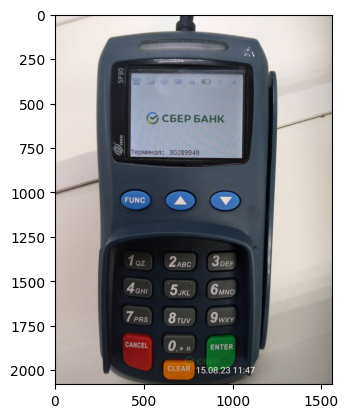

terminal_damaged:	0
terminal_undamaged:	1
terminal_unrecognized_defect:	0


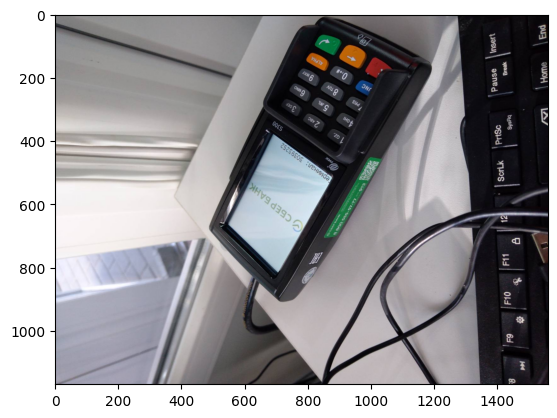

terminal_damaged:	1
terminal_undamaged:	0
terminal_unrecognized_defect:	0


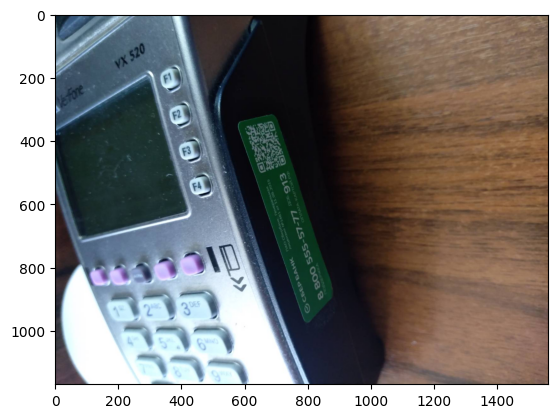

terminal_damaged:	0
terminal_undamaged:	0
terminal_unrecognized_defect:	1


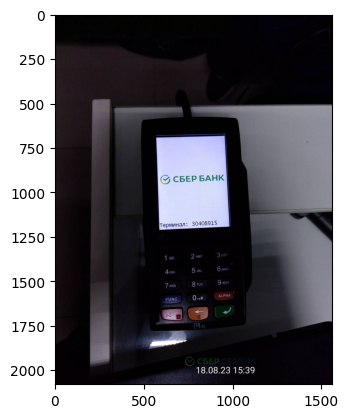

terminal_damaged:	0
terminal_undamaged:	1
terminal_unrecognized_defect:	0


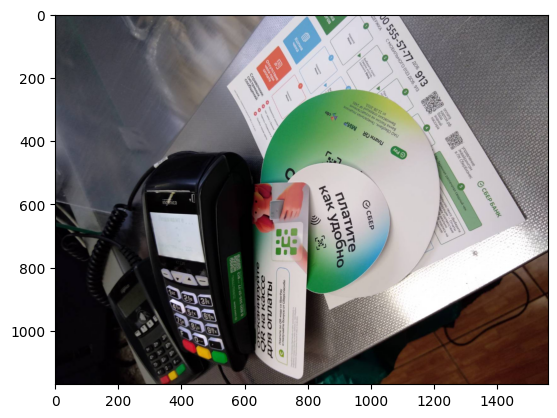

In [37]:
for row in df.sample(5).iterrows():
    row = row[1]
    img = Image.open(row['file_name'])
    print(f'terminal_damaged:\t{row["terminal_damaged"]}\nterminal_undamaged:\t{row["terminal_undamaged"]}\nterminal_unrecognized_defect:\t{row["terminal_unrecognized_defect"]}')
    plt.imshow(img)
    plt.show()

In [38]:
cols = ['file_name', 'terminal_damaged', 'terminal_undamaged', 'terminal_unrecognized_defect']
df = df[cols]
# train, test_terminal = train_test_split(
#     df, stratify=df['terminal'], test_size=0.25, random_state=RANDOM_STATE
# )

In [39]:
df['target'] = ''
df.loc[
    df['terminal_damaged']==1, 'target'
] = 'damaged'
df.loc[
    df['terminal_undamaged']==1, 'target'
] = 'undamaged'
df.loc[
    df['terminal_unrecognized_defect']==1, 'target'
] = 'unrecognized'

In [40]:
df['target'].value_counts()

target
undamaged       2920
damaged         1264
unrecognized     254
Name: count, dtype: int64

In [41]:
train, test = train_test_split(
    df, stratify=df['target'], test_size=0.25, random_state=RANDOM_STATE
)

In [42]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [43]:
NUM_WORKERS = 0 # os.cpu_count()
BATCH_SIZE = 32

train_dataset = CustomDataset(train, target_column='target', transform=train_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

test_dataset = CustomDataset(test, target_column='target', transform=test_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [44]:
from sklearn.metrics import confusion_matrix

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies, train_f1s, test_f1s):
    clear_output()
    fig, axs = plt.subplots(1, 3, figsize=(20, 10))
    plt.rcParams['font.size'] = '12'
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    axs[2].plot(range(1, len(train_f1s) + 1), train_f1s, label='train')
    axs[2].plot(range(1, len(test_f1s) + 1), test_f1s, label='test')
    axs[2].set_ylabel('F1')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()
    plt.show()

def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy, f1_score_value = 0.0, 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)  # labels: batch_size

        optimizer.zero_grad()
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

        # Calculate F1-score
        predictions = logits.argmax(dim=1)
        f1_score_value += f1_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    f1_score_value /= len(train_loader)

    return train_loss, train_accuracy, f1_score_value


@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    test_loss, test_accuracy, test_f1 = 0.0, 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)  # labels: batch_size
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=1) == labels).sum().item()
        # Calculate F1-score
        predictions = logits.argmax(dim=1)
        test_f1 += f1_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    test_f1 /= len(test_loader)

    return test_loss, test_accuracy, test_f1


def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs):
    train_losses, train_accuracies, train_f1s = [], [], []
    test_losses, test_accuracies, test_f1s = [], [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy, train_f1 = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_accuracy, test_f1 = validation_epoch(
            model, criterion, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        train_f1s += [train_f1]
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        test_f1s += [test_f1]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies, train_f1s, test_f1s)

    return train_losses, test_losses, train_accuracies, test_accuracies, train_f1s, test_f1s

In [45]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

In [46]:
imgs, lbls = next(iter(train_dataloader))

In [48]:
num_epochs = 30

model_terminal = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
model_terminal.classifier[1] = torch.nn.Linear(1280, 3)
model_terminal = model_terminal.to(device)
optimizer = torch.optim.SGD(model_terminal.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

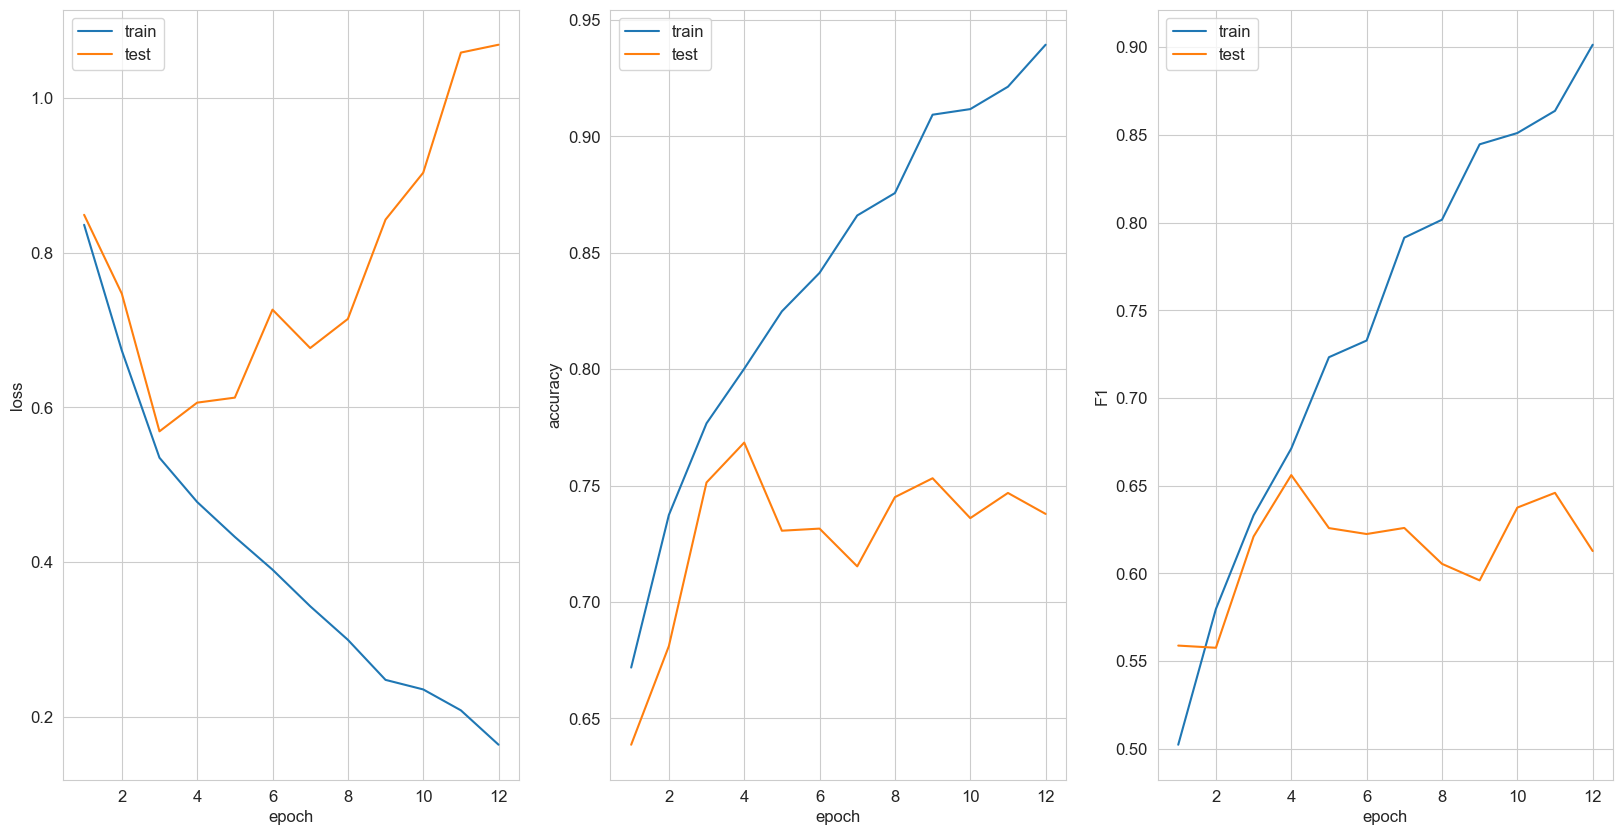

Training 13/30:  93%|█████████▎| 97/104 [01:22<00:05,  1.17it/s]


KeyboardInterrupt: 

In [49]:
train_losses, test_losses, train_accuracies, test_accuracies, train_f1s, test_f1s = train(
    model_terminal, optimizer, scheduler, criterion, train_dataloader, test_dataloader, num_epochs
)

Не сработало :(

In [55]:
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights

num_epochs = 30

model_terminal = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1)
model_terminal.classifier[3] = torch.nn.Linear(1280, 3)
model_terminal = model_terminal.to(device)
optimizer = torch.optim.SGD(model_terminal.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

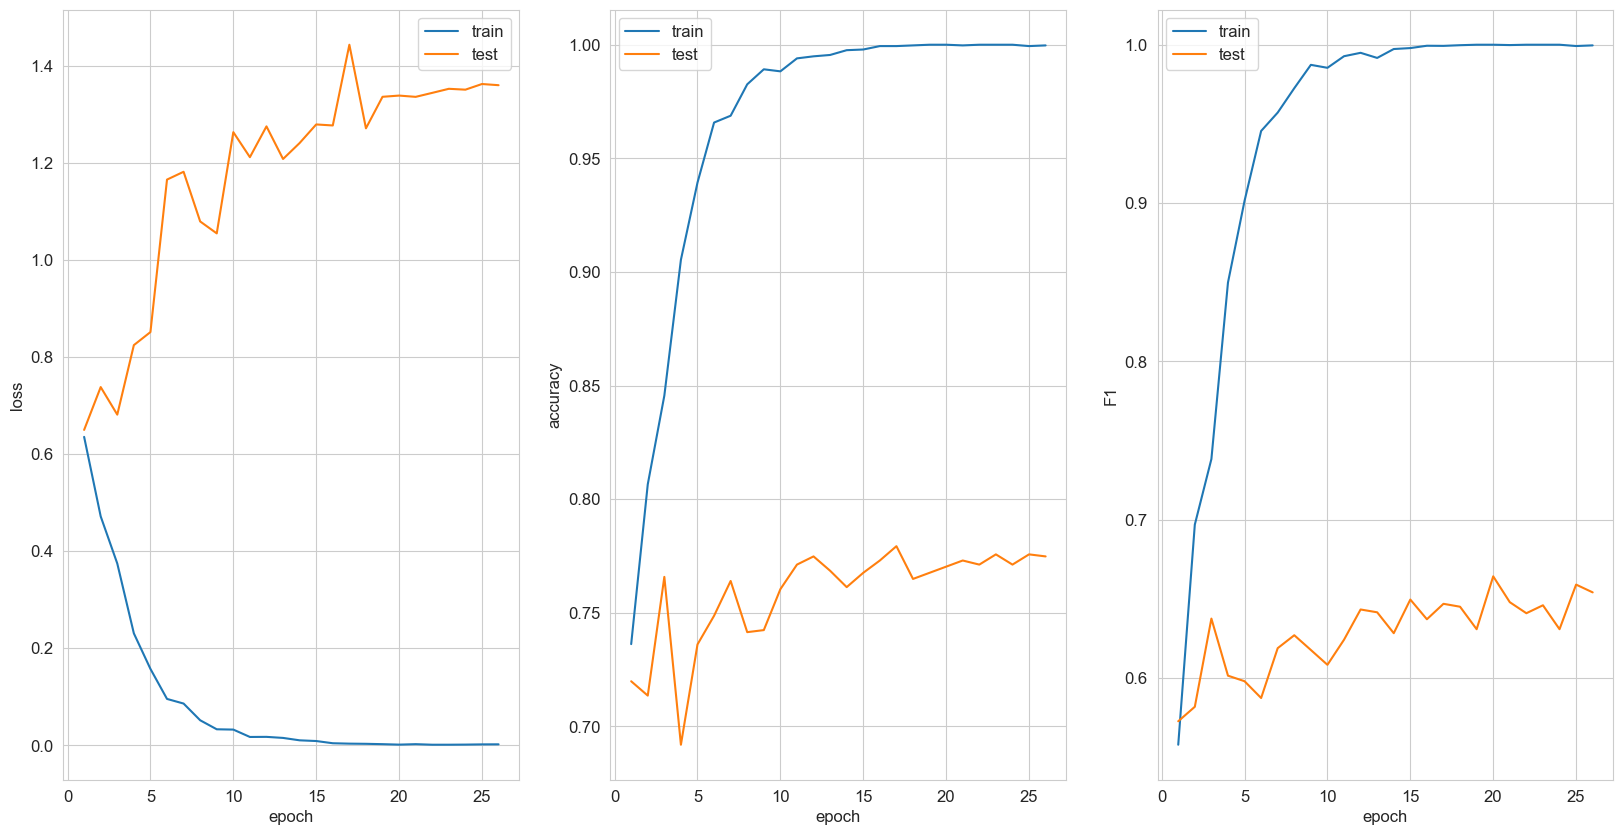

Training 27/30:   5%|▍         | 5/104 [00:04<01:33,  1.06it/s]


KeyboardInterrupt: 

In [58]:
train_losses, test_losses, train_accuracies, test_accuracies, train_f1s, test_f1s = train(
    model_terminal, optimizer, scheduler, criterion, train_dataloader, test_dataloader, num_epochs
)